In [123]:
import datetime
print('Last updated:', datetime.datetime.now(), '(PT)')

Last updated: 2020-07-17 18:17:59.976508 (PT)


In [124]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src/dp-gmm/util')
from pystan_vb_extract import pystan_vb_extract
import copy
from scipy.special import logsumexp

In [125]:
import pystan
from scipy.stats import multivariate_normal

In [261]:
# See: https://maggielieu.com/2017/03/21/multivariate-gaussian-mixture-model-done-properly/
# See: https://mc-stan.org/docs/2_19/stan-users-guide/gaussian-process-regression.html
warped_mixture = """
data {
    int D;               // number of dimensions
    int K;               // number of gaussians
    int N;               // number of data
    matrix[N,D] y;       // data
    vector[K] eta;       // dirichlet parameter
    real<lower=0> eps;   // nugget for exponential kernel for stability.
    matrix[D, D] S;
    real<lower=0> s_mu;
    real m_rho;
    real<lower=0> s_rho;
}
parameters {
    simplex[K] w;                 // mixing proportions
    ordered[D] mu[K];             // mixture component means
    real<lower=0> rho;            // range parameter in GP covariance fn
    matrix[N,D] x;                // latent parameters
}
transformed parameters {
    real soft_c[N, K]; // log unnormalized clusters
    for (n in 1:N) {
        for (k in 1:K) {
            soft_c[n, k] = log(w[k]) + multi_normal_lpdf(x[n, :] | mu[k], S);
        }
    }
}
model {
    matrix[N, N] KK[D];  // GP covariance matrices
    matrix[N, N] LK;  // cholesky of GP covariances

    w ~ dirichlet(eta);  // mixture weights
    rho ~ lognormal(m_rho, s_rho);  // GP covariance function range parameter
   
    for(k in 1:K){
       mu[k] ~ normal(0, s_mu);  // prior mixture locations (D-dim for each k)
    }
    
    for (n in 1:N){
       // GMM
       target += log_sum_exp(soft_c[n, :]);
    }
    
    for (d in 1:D) {
        KK[d] = cov_exp_quad(to_array_1d(x[:, d]), 1.0, rho); 
        
        // diagonal elements
        for (n in 1:N) {
            KK[d][n, n] = KK[d][n, n] + eps;
        }
        
        LK = cholesky_decompose(KK[d]);

        // Marginalized GP likelihood.
        y[:, d] ~ multi_normal_cholesky(rep_vector(0.0, N), LK);
    }
}
"""

In [262]:
%%time
sm = pystan.StanModel(model_code=warped_mixture)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8cefcf07e211dc11dfdc90b2c449f640 NOW.


CPU times: user 1.1 s, sys: 52 ms, total: 1.15 s
Wall time: 56.9 s


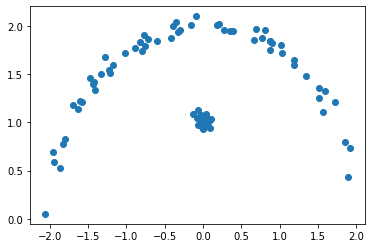

In [263]:
def gen_rainbow_data(N1=60, N2=30, r=2, s=0.1, sx=0.01, sy=0.01):
    x1 = np.random.rand(N1) * 2 * r - r
    y1 = np.sqrt(r*r - x1*x1)
    x2 = np.random.randn(N2) * sx
    y2 = np.random.randn(N2) * sy + 1
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    z = np.stack([x, y], axis=1)
    return z + np.random.randn(N1 + N2, 2) * s

# Generate data
np.random.seed(1)
y = gen_rainbow_data(s=0.05)
plt.scatter(y[:, 0], y[:, 1]);

In [309]:
# Data dictionary
K = 10
N, D = y.shape
data = dict(y=y, D=D, N=N, K=K, eta=np.full(K, 1/K**2), eps=1e-1, S=np.eye(D) / 100, s_mu=10, m_rho=0, s_rho=1)
init = dict(x=y)

## ADVI

In [ ]:
# %%time
# Fit via ADVI
vb_fit = sm.vb(data=data, iter=20000, seed=1)
samples = pystan_vb_extract(vb_fit)

## Plots

In [ ]:
plt.boxplot(samples['w']);

In [ ]:
x = samples['x']
mu = samples['mu']
w_mean = samples['w'].mean(0)
x_mean = x.mean(0)

In [ ]:
# FIXME: Something looks off here...
for xi in x:
    plt.scatter(xi[:, 0], xi[:, 1], c='black', s=1, alpha=0.1)

for k in range(data['K']):
    if w_mean[k] > 0:
        plt.scatter(mu[:, k, 0], mu[:, k, 1], alpha=w_mean[k], s=1);
        
plt.ylim(-3, 3)        

In [ ]:
def compute_probs(soft_c):
    unnormalized_probs = soft_c - logsumexp(soft_c, axis=-1, keepdims=True)
    return np.exp(unnormalized_probs)

In [ ]:
probs = compute_probs(samples['soft_c'])
probs.mean(0).argmax(1)

In [ ]:
# labels = probs.mean(0).argmax(-1)
labels = probs[0, :, :].argmax(-1)
plt.scatter(y[:, 0], y[:, 1], c=labels);

In [ ]:
plt.hist(samples['rho']);